# 全连接神经网络

在前面的作业中，你在CIFAR-10上实现了一个两层的全连接神经网络。那个实现很简单，但不是很模块化，因为损失和梯度计算在一个函数内。对于一个简单的两层网络来说，还可以人为处理，但是当我们使用更大的模型时，人工处理损失和梯度就变得不切实际了。理想情况下，我们希望使用更加模块化的设计来构建网络，这样我们就可以独立地实现不同类型的层，然后将它们整合到不同架构的模型中。

在本练习中，我们将使用更模块化的方法实现全连接网络。对于每一层，我们将实现一个`forward`和一个`backward`的函数。`forward`函数将接收输入、权重和其他参数，并返回一个输出和一个`cache`对象，存储反向传播所需的数据，如下所示：

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

反向传播将接收上游的梯度和`cache`对象，并返回相对于输入和权重的梯度：

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

以这种方式实现了一些层之后，我们能够轻松地将它们组合起来，以构建不同架构的分类器。

除了实现任意深度的全连接网络外，我们还将探索不同的优化更新规则，并引入Dropout作为正则化器和Batch/Layer归一化工具来更有效地优化网络。
  

In [1]:
## 先下载数据集到指定位置
%cd daseCV/datasets/
!bash get_datasets.sh
%cd ../..

/home/public/10205501415-710-123/daseCV/datasets
--2022-11-21 03:04:28--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  4.94MB/s    in 21s     

2022-11-21 03:05:00 (7.77 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/home/public/10205501415-710-123


In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from daseCV.classifiers.fc_net import *
from daseCV.data_utils import get_CIFAR10_data
from daseCV.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from daseCV.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# 仿射层：前向传播
打开 `daseCV/layers.py` 并实现 `affine_forward` 函数。

当你完成上述函数后，你可以用下面的代码测试你的实现正确与否

In [4]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)


out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# 仿射层：反向传播
实现 `affine_backwards` 函数，并使用数值梯度检查测试你的实现。

In [5]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU 激活函数：前向传播

在`relu_forward`函数中实现ReLU激活函数的前向传播，并使用以下代码测试您的实现:

In [6]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU 激活函数：反向传播

在`relu_back`函数中为ReLU激活函数实现反向传播，并使用数值梯度检查来测试你的实现

In [7]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

作业中只要求你实现ReLU,但是神经网络可以使用很多不同的激活函数,每个都有它的优点和缺点。但是，激活函数的一个常见问题是在反向传播时出现零(或接近零)梯度流。下列哪个激活函数会有这个问题？如果在一维情况下考虑这些函数，什么样的输入将会发生这种现象？
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
[Sigmoid激活函数、LeakyReLU激活函数与ReLU函数都会存在出现零梯度流的问题，对于Sigmoid函数，当输入值很大或者很小时在反向传播的过程中由于连乘的原因会出现梯度接近于零的梯度流；对于ReLU函数，但输入值为负时，该神经元不能被激活，梯度计算为0；对于LeakyReLU函数，因为leak为值比较小的函数，在输入值去负时，对应的梯度为leak，又因为连乘的原因使得梯度会接近于0]


# “三明治” 层

在神经网络中有一些常用的层模式。例如，仿射层后面经常跟一个ReLU层。为了简化这些常见模式，我们在文件`daseCV/layer_utils.py`中定义了几个常用的层

请查看 `affine_relu_forward` 和 `affine_relu_backward` 函数, 并且运行下列代码进行数值梯度检查：

x --> z1=xw1+b1 --> a1=ReLU(z1) --> z2=a1w2+b2 --> a2=ReLU(z2) --> .... 

In [8]:
from daseCV.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# 损失层：Softmax and SVM

在上次作业中你已经实现了这些损失函数，所以这次作业就不用做了，免费送你了。当然，你仍然应该通过查看`daseCV/layers.py`其中的实现来确保理解它们是如何工作的。

你可以通过运行以下程序来确保实现是正确的:

In [9]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# 两层网络

在之前的作业中，你已经实现了一个简单的两层神经网络。现在你已经模块化地实现了一些层，你将使用这些模块重新实现两层网络。

打开文件`daseCV/classifiers/fc_net`。并完成`TwoLayerNet`类的实现。这个类将作为这个作业中其他网络的模块，所以请通读它以确保你理解了这个API。
你可以运行下面的单元来测试您的实现。


In [10]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
# print("loss: ",loss)
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.21e-10
b1 relative error: 8.37e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver

在之前的作业中，模型的训练逻辑与模型本身是耦合的。在这次作业中，按照更加模块化的设计，我们将模型的训练逻辑划分为单独的类。

打开文件`daseCV/solver`，通读一遍以熟悉API。然后使用一个`Sovler`实例来训练一个`TwoLayerNet`，它可以在验证集上达到至少`50%`的精度。

In [11]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model,data,update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)

solver.train()

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 101 / 4900) loss: 1.829613
(Iteration 201 / 4900) loss: 1.857390
(Iteration 301 / 4900) loss: 1.744448
(Iteration 401 / 4900) loss: 1.420187
(Epoch 1 / 10) train acc: 0.407000; val_acc: 0.422000
(Iteration 501 / 4900) loss: 1.565913
(Iteration 601 / 4900) loss: 1.700510
(Iteration 701 / 4900) loss: 1.732213
(Iteration 801 / 4900) loss: 1.688361
(Iteration 901 / 4900) loss: 1.439529
(Epoch 2 / 10) train acc: 0.497000; val_acc: 0.468000
(Iteration 1001 / 4900) loss: 1.385772
(Iteration 1101 / 4900) loss: 1.278401
(Iteration 1201 / 4900) loss: 1.641580
(Iteration 1301 / 4900) loss: 1.438847
(Iteration 1401 / 4900) loss: 1.172536
(Epoch 3 / 10) train acc: 0.490000; val_acc: 0.466000
(Iteration 1501 / 4900) loss: 1.346286
(Iteration 1601 / 4900) loss: 1.268492
(Iteration 1701 / 4900) loss: 1.318215
(Iteration 1801 / 4900) loss: 1.395750
(Iteration 1901 / 4900) loss: 1.338233
(Epoch 4 / 10) t

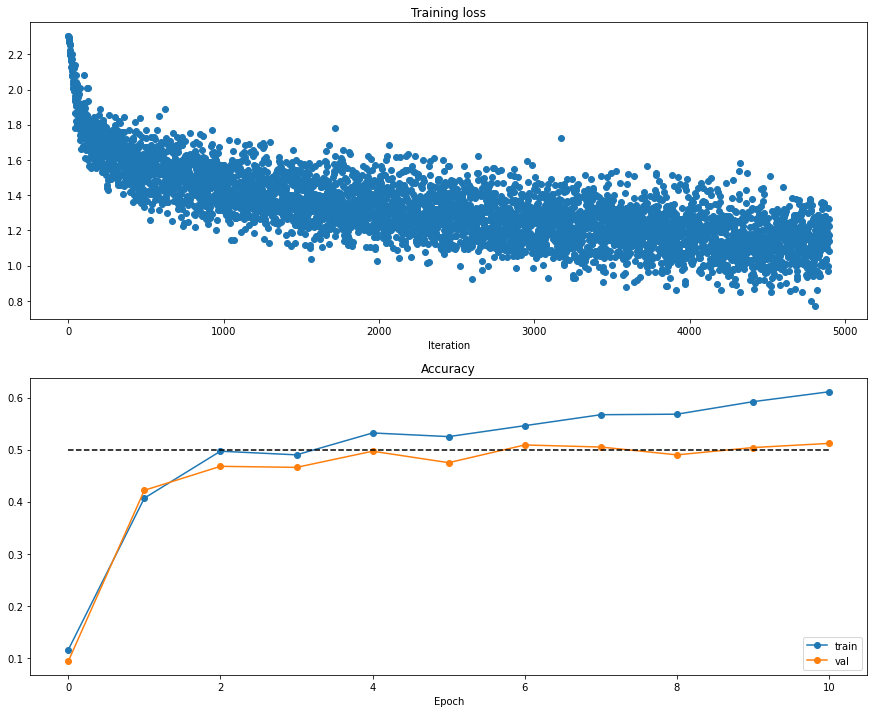

In [12]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# 多层网络

接下来，请实现一个带有任意数量的隐层的全连接网络。

阅读`daseCV/classifiers/fc_net.py`中的`FullyConnectedNet`类。

实现初始化、前向传播和反向传播的函数，暂时不要考虑实现dropout或batch/layer normalization，我们将在后面添加上去。

## 初始化loss和梯度检查

刚开始要做完整性检查，运行以下代码来检查初始loss，并对有正则化和无正则化的网络进行梯度检查。请问初始的loss合理吗?

在梯度检查中，你应该期望得到1e-7或更少的errors。

In [13]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.638793811090764
W1 relative error: 1.57e-08
W2 relative error: 4.68e-08
W3 relative error: 1.45e-06
b1 relative error: 3.94e-10
b2 relative error: 1.23e-10
b3 relative error: 3.68e-10
Running check with reg =  3.14
Initial loss:  451.3464813074225
W1 relative error: 3.12e-07
W2 relative error: 1.39e-06
W3 relative error: 4.72e-08
b1 relative error: 2.08e-08
b2 relative error: 3.45e-08
b3 relative error: 9.95e-08


实现另一个完整性检查，请确保你可以过拟合50个图像的小数据集。首先，我们将尝试一个三层网络，每个隐藏层有100个单元。在接下来的代码中，调整**learning rate**和**weight initialization scale**以达到过拟合，在20 epoch内达到100%的训练精度。

(Iteration 1 / 40) loss: 27.948607
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.160000
(Epoch 1 / 20) train acc: 0.420000; val_acc: 0.145000
(Epoch 2 / 20) train acc: 0.700000; val_acc: 0.143000
(Epoch 3 / 20) train acc: 0.760000; val_acc: 0.168000
(Epoch 4 / 20) train acc: 0.880000; val_acc: 0.158000
(Epoch 5 / 20) train acc: 0.920000; val_acc: 0.164000
(Iteration 11 / 40) loss: 1.056135
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.145000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.166000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.162000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.159000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.159000
(Iteration 21 / 40) loss: 0.003744
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.157000
(Iteration 31 / 40) loss:

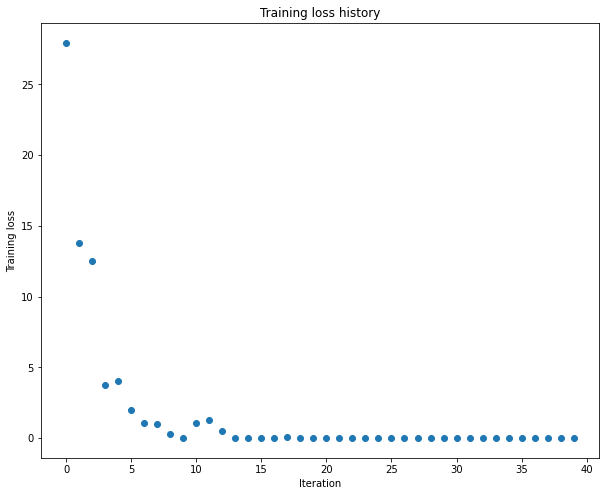

In [14]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-4  # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

现在尝试使用一个五层的网络，每层100个单元，对50张图片进行训练。同样，你将调整learning rate和weight initialization scale比例，你应该能够在20个epoch内实现100%的训练精度。

(Iteration 1 / 40) loss: 2.713918
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.078000
(Epoch 1 / 20) train acc: 0.100000; val_acc: 0.078000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.091000
(Epoch 3 / 20) train acc: 0.260000; val_acc: 0.128000
(Epoch 4 / 20) train acc: 0.300000; val_acc: 0.147000
(Epoch 5 / 20) train acc: 0.300000; val_acc: 0.142000
(Iteration 11 / 40) loss: 1.630379
(Epoch 6 / 20) train acc: 0.240000; val_acc: 0.125000
(Epoch 7 / 20) train acc: 0.380000; val_acc: 0.141000
(Epoch 8 / 20) train acc: 0.560000; val_acc: 0.137000
(Epoch 9 / 20) train acc: 0.660000; val_acc: 0.134000
(Epoch 10 / 20) train acc: 0.780000; val_acc: 0.143000
(Iteration 21 / 40) loss: 1.217063
(Epoch 11 / 20) train acc: 0.560000; val_acc: 0.114000
(Epoch 12 / 20) train acc: 0.500000; val_acc: 0.165000
(Epoch 13 / 20) train acc: 0.760000; val_acc: 0.175000
(Epoch 14 / 20) train acc: 0.860000; val_acc: 0.178000
(Epoch 15 / 20) train acc: 0.880000; val_acc: 0.167000
(Iteration 31 / 40) loss: 

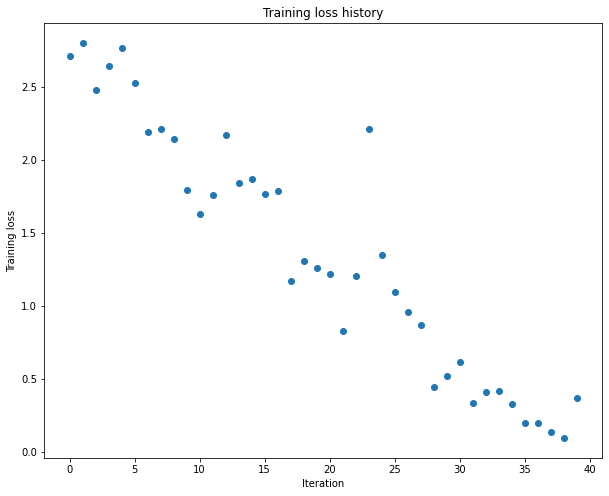

In [15]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2 # Experiment with this!
learning_rate = 8e-3  # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

#### Inline Question 2: 
你注意到训练三层网和训练五层网难度的区别了吗？根据你的经验，哪个网络对initalization scale更敏感?为什么会这样呢?

## Answer:
[注意到了（ ᗜ ‸ ᗜ ），虽然3层神经网络和5层神经网络虽然训练集都能达到100%，但是5层的调参过程更加困难，同时在验证集上3层神经网络可以实现更好的泛化能力。5层神经网络对权重初始化scale更加敏感，因为5层网络更加复杂，参数更多，也使得loss函数更加复杂，更容易陷入局部极小点。]


# 更新规则

到目前为止，我们使用了普通的随机梯度下降法(SGD)作为我们的更新规则。更复杂的更新规则可以更容易地训练深度网络。我们将实现一些最常用的更新规则，并将它们与普通的SGD进行比较。

# SGD+Momentum

带动量的随机梯度下降法是一种广泛使用的更新规则，它使深度网络的收敛速度快于普通的随机梯度下降法。更多信息参见http://cs231n.github.io/neural-networks-3/#sgd 动量更新部分。

打开文件`daseCV/optim`，并阅读该文件顶部的文档，以确保你理解了该API。在函数`sgd_momentum`中实现SGD+动量更新规则，并运行以下代码检查你的实现。你会看到errors小于e-8。

In [16]:
from daseCV.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


当你完成了上面的步骤，运行以下代码来训练一个具有SGD和SGD+momentum的六层网络。你应该看到SGD+momentum更新规则收敛得更快。


running with  sgd
(Iteration 1 / 200) loss: 22.083557
(Epoch 0 / 5) train acc: 0.097000; val_acc: 0.113000
(Iteration 11 / 200) loss: 2.502334
(Iteration 21 / 200) loss: 2.529047
(Iteration 31 / 200) loss: 2.111055
(Epoch 1 / 5) train acc: 0.207000; val_acc: 0.185000
(Iteration 41 / 200) loss: 2.051560
(Iteration 51 / 200) loss: 2.017934
(Iteration 61 / 200) loss: 1.860452
(Iteration 71 / 200) loss: 1.983822
(Epoch 2 / 5) train acc: 0.335000; val_acc: 0.216000
(Iteration 81 / 200) loss: 1.920696
(Iteration 91 / 200) loss: 1.965837
(Iteration 101 / 200) loss: 1.813681
(Iteration 111 / 200) loss: 1.836827
(Epoch 3 / 5) train acc: 0.374000; val_acc: 0.239000
(Iteration 121 / 200) loss: 1.814679
(Iteration 131 / 200) loss: 1.693633
(Iteration 141 / 200) loss: 1.681794
(Iteration 151 / 200) loss: 1.631829
(Epoch 4 / 5) train acc: 0.409000; val_acc: 0.258000
(Iteration 161 / 200) loss: 1.596002
(Iteration 171 / 200) loss: 1.522256
(Iteration 181 / 200) loss: 1.411821
(Iteration 191 / 200) lo

/home/public/10205501415-710-123/daseCV/classifiers/fc_net.py:428: RuntimeWarning: overflow encountered in square
  loss += 0.5 * self.reg * np.sum(self.params['W' + str(self.num_layers - i)] ** 2)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/public/10205501415-710-123/daseCV/classifiers/fc_net.py:428: RuntimeWarning: invalid value encountered in multiply
  loss += 0.5 * self.reg * np.sum(self.params['W' + str(self.num_layers - i)] ** 2)


(Iteration 21 / 200) loss: nan
(Iteration 31 / 200) loss: nan
(Epoch 1 / 5) train acc: 0.083000; val_acc: 0.087000
(Iteration 41 / 200) loss: nan
(Iteration 51 / 200) loss: nan
(Iteration 61 / 200) loss: nan
(Iteration 71 / 200) loss: nan
(Epoch 2 / 5) train acc: 0.118000; val_acc: 0.087000
(Iteration 81 / 200) loss: nan
(Iteration 91 / 200) loss: nan
(Iteration 101 / 200) loss: nan
(Iteration 111 / 200) loss: nan
(Epoch 3 / 5) train acc: 0.097000; val_acc: 0.087000
(Iteration 121 / 200) loss: nan
(Iteration 131 / 200) loss: nan
(Iteration 141 / 200) loss: nan
(Iteration 151 / 200) loss: nan
(Epoch 4 / 5) train acc: 0.083000; val_acc: 0.087000
(Iteration 161 / 200) loss: nan
(Iteration 171 / 200) loss: nan
(Iteration 181 / 200) loss: nan
(Iteration 191 / 200) loss: nan
(Epoch 5 / 5) train acc: 0.109000; val_acc: 0.087000



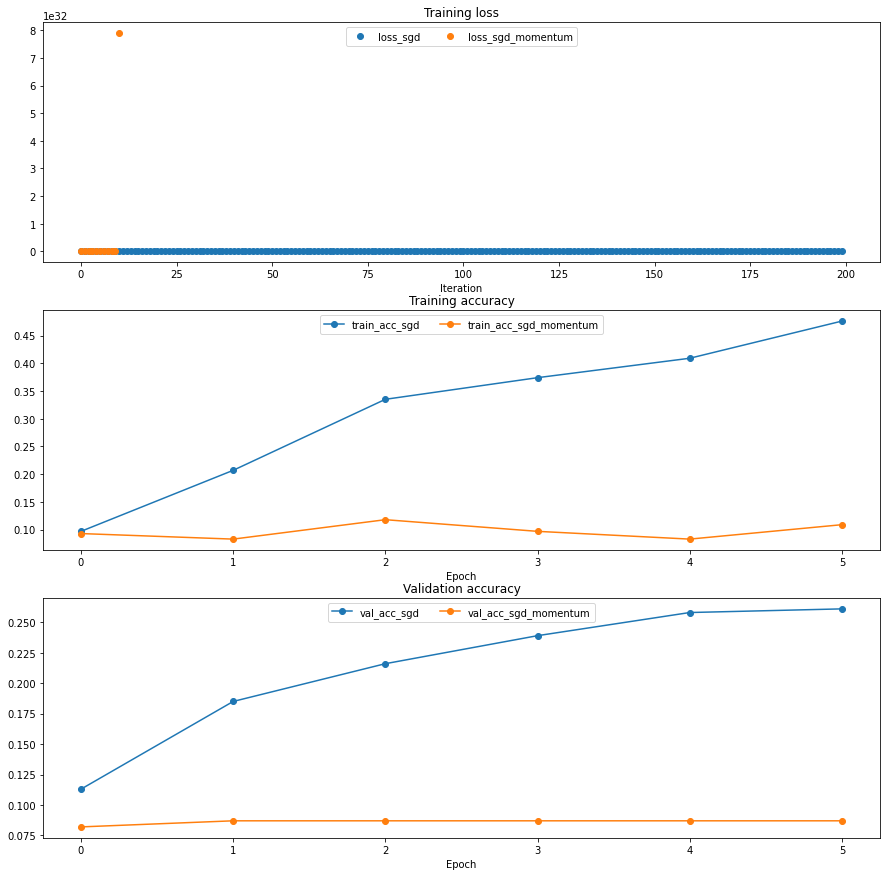

In [17]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam

RMSProp [1] 和Adam [2] 是另外两个更新规则，它们通过使用梯度的二阶矩平均值来设置每个参数的学习速率。

在文件`daseCV/optim`中实现`RMSProp`函数和`Adam`函数，并使用下面的代码来检查您的实现。

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [18]:
# Test RMSProp implementation
from daseCV.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [19]:
# Test Adam implementation
from daseCV.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  0.20720703668629928
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


当你完成了上面RMSProp和Adam函数后，运行下面的代码训练一对网络，其中分别使用了上述两个方法

running with  adam
(Iteration 1 / 200) loss: 28.614160
(Epoch 0 / 5) train acc: 0.127000; val_acc: 0.124000
(Iteration 11 / 200) loss: 5.336951
(Iteration 21 / 200) loss: 2.494446
(Iteration 31 / 200) loss: 2.285899
(Epoch 1 / 5) train acc: 0.174000; val_acc: 0.142000
(Iteration 41 / 200) loss: 2.262317
(Iteration 51 / 200) loss: 2.248608
(Iteration 61 / 200) loss: 2.035429
(Iteration 71 / 200) loss: 2.178052
(Epoch 2 / 5) train acc: 0.215000; val_acc: 0.192000
(Iteration 81 / 200) loss: 2.200674
(Iteration 91 / 200) loss: 1.989022
(Iteration 101 / 200) loss: 2.125556
(Iteration 111 / 200) loss: 2.020956
(Epoch 3 / 5) train acc: 0.237000; val_acc: 0.208000
(Iteration 121 / 200) loss: 1.943172
(Iteration 131 / 200) loss: 2.143179
(Iteration 141 / 200) loss: 1.947961
(Iteration 151 / 200) loss: 1.898021
(Epoch 4 / 5) train acc: 0.299000; val_acc: 0.266000
(Iteration 161 / 200) loss: 1.984794
(Iteration 171 / 200) loss: 1.959926
(Iteration 181 / 200) loss: 1.994785
(Iteration 191 / 200) l

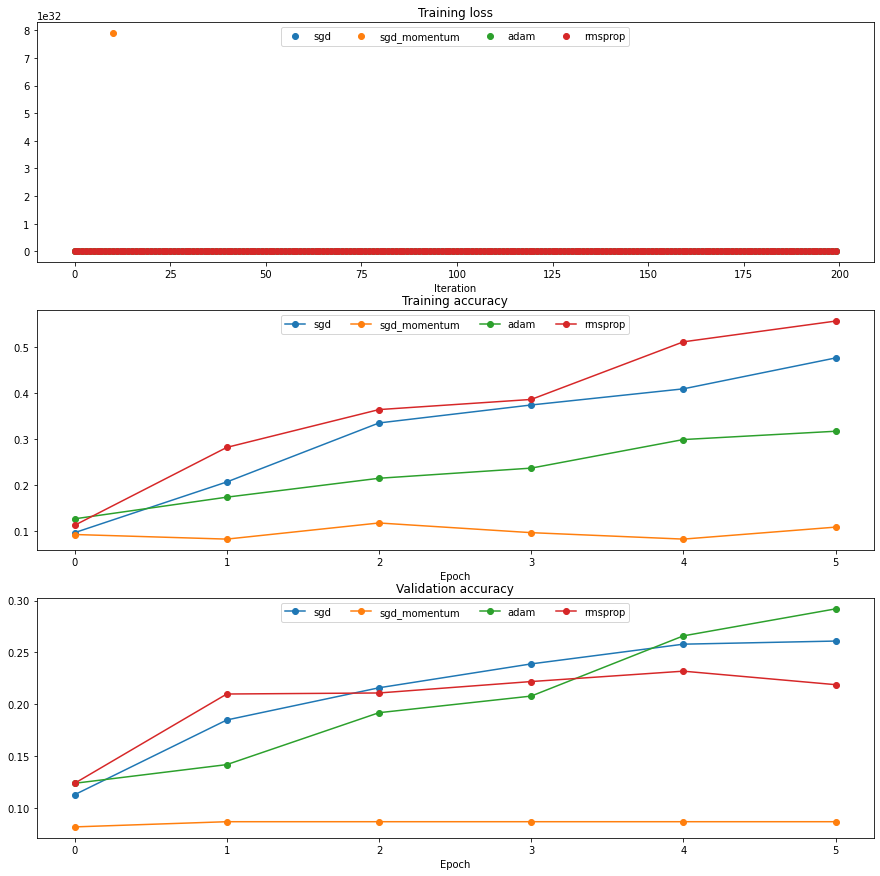

In [20]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad，类似于Adam，是一个per-parameter优化方法，它使用以下更新规则:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

当使用AdaGrad训练一个网络时，更新的值会变得非常小，而且他的网络学习的非常慢。利用你对AdaGrad更新规则的了解，解释为什么更新的值会变得非常小？ Adam会有同样的问题吗？

## Answer: 
[在反向传播的过程中，dw初始的值较大，导致cache积累的非常大，所以在更新的时候，会使得learning_rate * dw / (np.sqrt(cache) + eps)的值非常的小，所以使得w收敛非常慢。
对于Adam方法并不会有这个问题，在Adam方法中使用W = W - learning_rate*( vdW/sqrt(sDW) )，b = b - learning_rate*( vdb/sqrt(sDb) )每次更新之前会对dw，db进行运算vdW1 = betaV*vdW0 + (1-beta)*dw1，vdb1 = betaV*vdb0 + (1-beta)*db1会使得取值范围正常]


# 训练一个效果足够好的模型！

在CIFAR-10上尽可能训练最好的全连接模型，将最好的模型存储在`best_model`变量中。我们要求你在验证集上获得至少50%的准确性。

如果你细心的话，应该是有可能得到55%以上精度的，但我们不苛求你达到这么高的精度。在后面的作业上，我们会要求你们在CIFAR-10上训练最好的卷积神经网络，我们希望你们把精力放在卷积网络上，而不是全连接网络上。

在做这部分之前完成`BatchNormalization.ipynb`和`Dropout.ipynb`可能会对你有帮助，因为这些技术可以帮助你训练强大的模型。

In [26]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_acc = 0
for learning_rate in [1e-3, 1e-4]:
    for reg in [1e-2, 1e-3, 1e-4]:
        for update_rule in ['rmsprop','adam']: ## 考虑更新方式
            for dropout in [1,0.75,0.5,0.25]:  ## 考虑是否dropout
                for normalization in [None,'batchnorm']: ## 考虑是否normalization
#                     if normalization_modes == 0:
#                         normalization = None
#                     else normalization_modes == 1:
#                         normalization = 'batchnorm'
                    
                    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, reg = reg,normalization=normalization,dropout=dropout)
                    ## print("start")
                    solver = Solver(model, data,
                                  num_epochs=10, batch_size=200,
                                  update_rule='rmsprop',
                                  optim_config={
                                    'learning_rate': learning_rate
                                  },
                                  verbose=True, print_every=300)
                    solver.train()
                    ## print("end")
                    print ('learning_rate = %f, reg = %f, best val loss = %f, dropout = %s, normalization = %s' %(learning_rate, reg, solver.best_val_acc, dropout, normalization))
                    if solver.best_val_acc > best_acc:
                        best_acc = solver.best_val_acc
                        best_model = model

pass

 

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 2450) loss: 34.721025
(Epoch 0 / 10) train acc: 0.090000; val_acc: 0.079000
(Epoch 1 / 10) train acc: 0.362000; val_acc: 0.326000
(Iteration 301 / 2450) loss: 7.997324
(Epoch 2 / 10) train acc: 0.364000; val_acc: 0.376000
(Iteration 601 / 2450) loss: 5.063384
(Epoch 3 / 10) train acc: 0.463000; val_acc: 0.411000
(Iteration 901 / 2450) loss: 3.606725
(Epoch 4 / 10) train acc: 0.428000; val_acc: 0.423000
(Iteration 1201 / 2450) loss: 2.791561
(Epoch 5 / 10) train acc: 0.471000; val_acc: 0.446000
(Epoch 6 / 10) train acc: 0.398000; val_acc: 0.428000
(Iteration 1501 / 2450) loss: 2.309831
(Epoch 7 / 10) train acc: 0.455000; val_acc: 0.439000
(Iteration 1801 / 2450) loss: 2.018140
(Epoch 8 / 10) train acc: 0.475000; val_acc: 0.433000
(Iteration 2101 / 2450) loss: 1.926194
(Epoch 9 / 10) train acc: 0.484000; val_acc: 0.444000
(Iteration 2401 / 2450) loss: 1.933574
(Epoch 10 / 10) train acc: 0.484000; val_acc: 0.475000
learning_rate = 0.001000, reg = 0.010000, best val loss = 0

(Epoch 1 / 10) train acc: 0.321000; val_acc: 0.328000
(Iteration 301 / 2450) loss: 8.225076
(Epoch 2 / 10) train acc: 0.387000; val_acc: 0.366000
(Iteration 601 / 2450) loss: 5.555642
(Epoch 3 / 10) train acc: 0.377000; val_acc: 0.370000
(Iteration 901 / 2450) loss: 3.905917
(Epoch 4 / 10) train acc: 0.409000; val_acc: 0.414000
(Iteration 1201 / 2450) loss: 3.064350
(Epoch 5 / 10) train acc: 0.444000; val_acc: 0.444000
(Epoch 6 / 10) train acc: 0.427000; val_acc: 0.405000
(Iteration 1501 / 2450) loss: 2.603542
(Epoch 7 / 10) train acc: 0.454000; val_acc: 0.447000
(Iteration 1801 / 2450) loss: 2.110119
(Epoch 8 / 10) train acc: 0.480000; val_acc: 0.473000
(Iteration 2101 / 2450) loss: 2.101840
(Epoch 9 / 10) train acc: 0.507000; val_acc: 0.457000
(Iteration 2401 / 2450) loss: 1.952774
(Epoch 10 / 10) train acc: 0.449000; val_acc: 0.439000
learning_rate = 0.001000, reg = 0.010000, best val loss = 0.473000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 19.781696
(Epoch 0 / 

(Iteration 1 / 2450) loss: 24.922678
(Epoch 0 / 10) train acc: 0.105000; val_acc: 0.096000
(Epoch 1 / 10) train acc: 0.299000; val_acc: 0.336000
(Iteration 301 / 2450) loss: 2.723293
(Epoch 2 / 10) train acc: 0.394000; val_acc: 0.365000
(Iteration 601 / 2450) loss: 2.541093
(Epoch 3 / 10) train acc: 0.396000; val_acc: 0.385000
(Iteration 901 / 2450) loss: 2.330710
(Epoch 4 / 10) train acc: 0.406000; val_acc: 0.429000
(Iteration 1201 / 2450) loss: 1.931457
(Epoch 5 / 10) train acc: 0.485000; val_acc: 0.452000
(Epoch 6 / 10) train acc: 0.492000; val_acc: 0.473000
(Iteration 1501 / 2450) loss: 1.879844
(Epoch 7 / 10) train acc: 0.536000; val_acc: 0.446000
(Iteration 1801 / 2450) loss: 1.668030
(Epoch 8 / 10) train acc: 0.517000; val_acc: 0.446000
(Iteration 2101 / 2450) loss: 1.579906
(Epoch 9 / 10) train acc: 0.574000; val_acc: 0.493000
(Iteration 2401 / 2450) loss: 1.482937
(Epoch 10 / 10) train acc: 0.510000; val_acc: 0.468000
learning_rate = 0.001000, reg = 0.001000, best val loss = 0

(Epoch 10 / 10) train acc: 0.092000; val_acc: 0.114000
learning_rate = 0.001000, reg = 0.001000, best val loss = 0.151000, dropout = 0.25, normalization = batchnorm
(Iteration 1 / 2450) loss: 29.294949
(Epoch 0 / 10) train acc: 0.086000; val_acc: 0.074000
(Epoch 1 / 10) train acc: 0.319000; val_acc: 0.331000
(Iteration 301 / 2450) loss: 2.705330
(Epoch 2 / 10) train acc: 0.406000; val_acc: 0.400000
(Iteration 601 / 2450) loss: 2.349315
(Epoch 3 / 10) train acc: 0.425000; val_acc: 0.428000
(Iteration 901 / 2450) loss: 2.150123
(Epoch 4 / 10) train acc: 0.465000; val_acc: 0.456000
(Iteration 1201 / 2450) loss: 1.968454
(Epoch 5 / 10) train acc: 0.539000; val_acc: 0.464000
(Epoch 6 / 10) train acc: 0.512000; val_acc: 0.478000
(Iteration 1501 / 2450) loss: 1.910565
(Epoch 7 / 10) train acc: 0.490000; val_acc: 0.496000
(Iteration 1801 / 2450) loss: 1.623223
(Epoch 8 / 10) train acc: 0.527000; val_acc: 0.485000
(Iteration 2101 / 2450) loss: 1.791246
(Epoch 9 / 10) train acc: 0.559000; val_ac

(Iteration 2101 / 2450) loss: 1.368669
(Epoch 9 / 10) train acc: 0.527000; val_acc: 0.479000
(Iteration 2401 / 2450) loss: 1.285142
(Epoch 10 / 10) train acc: 0.515000; val_acc: 0.467000
learning_rate = 0.001000, reg = 0.000100, best val loss = 0.485000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 12.922720
(Epoch 0 / 10) train acc: 0.124000; val_acc: 0.140000
(Epoch 1 / 10) train acc: 0.192000; val_acc: 0.227000
(Iteration 301 / 2450) loss: 1.719359
(Epoch 2 / 10) train acc: 0.243000; val_acc: 0.252000
(Iteration 601 / 2450) loss: 1.530147
(Epoch 3 / 10) train acc: 0.278000; val_acc: 0.274000
(Iteration 901 / 2450) loss: 1.615468
(Epoch 4 / 10) train acc: 0.275000; val_acc: 0.256000
(Iteration 1201 / 2450) loss: 1.391574
(Epoch 5 / 10) train acc: 0.223000; val_acc: 0.204000
(Epoch 6 / 10) train acc: 0.314000; val_acc: 0.289000
(Iteration 1501 / 2450) loss: 1.201671
(Epoch 7 / 10) train acc: 0.308000; val_acc: 0.287000
(Iteration 1801 / 2450) loss: 1.233367
(Epoch 8 / 

(Iteration 1801 / 2450) loss: 1.590554
(Epoch 8 / 10) train acc: 0.506000; val_acc: 0.481000
(Iteration 2101 / 2450) loss: 1.356896
(Epoch 9 / 10) train acc: 0.522000; val_acc: 0.481000
(Iteration 2401 / 2450) loss: 1.356450
(Epoch 10 / 10) train acc: 0.554000; val_acc: 0.508000
learning_rate = 0.001000, reg = 0.000100, best val loss = 0.508000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 10.808255
(Epoch 0 / 10) train acc: 0.097000; val_acc: 0.118000
(Epoch 1 / 10) train acc: 0.210000; val_acc: 0.185000
(Iteration 301 / 2450) loss: 1.564360
(Epoch 2 / 10) train acc: 0.218000; val_acc: 0.185000
(Iteration 601 / 2450) loss: 1.516548
(Epoch 3 / 10) train acc: 0.255000; val_acc: 0.217000
(Iteration 901 / 2450) loss: 1.502278
(Epoch 4 / 10) train acc: 0.217000; val_acc: 0.209000
(Iteration 1201 / 2450) loss: 1.364369
(Epoch 5 / 10) train acc: 0.226000; val_acc: 0.210000
(Epoch 6 / 10) train acc: 0.201000; val_acc: 0.209000
(Iteration 1501 / 2450) loss: 1.281962
(Epoch 7 / 

(Iteration 1501 / 2450) loss: 8.666256
(Epoch 7 / 10) train acc: 0.466000; val_acc: 0.410000
(Iteration 1801 / 2450) loss: 7.926292
(Epoch 8 / 10) train acc: 0.486000; val_acc: 0.420000
(Iteration 2101 / 2450) loss: 7.617228
(Epoch 9 / 10) train acc: 0.506000; val_acc: 0.433000
(Iteration 2401 / 2450) loss: 7.069903
(Epoch 10 / 10) train acc: 0.541000; val_acc: 0.435000
learning_rate = 0.000100, reg = 0.010000, best val loss = 0.435000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 22.284370
(Epoch 0 / 10) train acc: 0.101000; val_acc: 0.094000
(Epoch 1 / 10) train acc: 0.189000; val_acc: 0.166000
(Iteration 301 / 2450) loss: 11.587270
(Epoch 2 / 10) train acc: 0.177000; val_acc: 0.184000
(Iteration 1201 / 2450) loss: 9.515262
(Epoch 5 / 10) train acc: 0.212000; val_acc: 0.200000
(Epoch 6 / 10) train acc: 0.214000; val_acc: 0.196000
(Iteration 1501 / 2450) loss: 8.964909
(Epoch 7 / 10) train acc: 0.225000; val_acc: 0.206000
(Iteration 1801 / 2450) loss: 8.461787
(Epoch 8

(Iteration 1501 / 2450) loss: 8.384141
(Epoch 7 / 10) train acc: 0.503000; val_acc: 0.443000
(Iteration 1801 / 2450) loss: 7.850365
(Epoch 8 / 10) train acc: 0.497000; val_acc: 0.441000
(Iteration 2101 / 2450) loss: 7.515875
(Epoch 9 / 10) train acc: 0.528000; val_acc: 0.443000
(Iteration 2401 / 2450) loss: 7.065873
(Epoch 10 / 10) train acc: 0.564000; val_acc: 0.452000
learning_rate = 0.000100, reg = 0.010000, best val loss = 0.452000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 20.426053
(Epoch 0 / 10) train acc: 0.152000; val_acc: 0.123000
(Epoch 1 / 10) train acc: 0.204000; val_acc: 0.209000
(Iteration 301 / 2450) loss: 11.248943
(Epoch 2 / 10) train acc: 0.241000; val_acc: 0.261000
(Iteration 601 / 2450) loss: 10.348100
(Epoch 3 / 10) train acc: 0.238000; val_acc: 0.277000
(Iteration 901 / 2450) loss: 9.427093
(Epoch 4 / 10) train acc: 0.238000; val_acc: 0.294000
(Iteration 1201 / 2450) loss: 8.975502
(Epoch 5 / 10) train acc: 0.242000; val_acc: 0.267000
(Epoch 6 

(Epoch 5 / 10) train acc: 0.452000; val_acc: 0.388000
(Epoch 6 / 10) train acc: 0.469000; val_acc: 0.418000
(Iteration 1501 / 2450) loss: 2.417992
(Epoch 7 / 10) train acc: 0.513000; val_acc: 0.415000
(Iteration 1801 / 2450) loss: 2.084607
(Epoch 8 / 10) train acc: 0.501000; val_acc: 0.434000
(Iteration 2101 / 2450) loss: 2.271666
(Epoch 9 / 10) train acc: 0.534000; val_acc: 0.437000
(Iteration 2401 / 2450) loss: 2.131629
(Epoch 10 / 10) train acc: 0.555000; val_acc: 0.430000
learning_rate = 0.000100, reg = 0.001000, best val loss = 0.437000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 10.917635
(Epoch 0 / 10) train acc: 0.092000; val_acc: 0.129000
(Epoch 1 / 10) train acc: 0.154000; val_acc: 0.163000
(Iteration 301 / 2450) loss: 3.365061
(Epoch 2 / 10) train acc: 0.144000; val_acc: 0.163000
(Iteration 601 / 2450) loss: 2.707009
(Epoch 3 / 10) train acc: 0.163000; val_acc: 0.176000
(Iteration 901 / 2450) loss: 2.478395
(Epoch 4 / 10) train acc: 0.185000; val_acc: 0.183

(Epoch 3 / 10) train acc: 0.358000; val_acc: 0.353000
(Iteration 901 / 2450) loss: 2.571573
(Epoch 4 / 10) train acc: 0.426000; val_acc: 0.372000
(Iteration 1201 / 2450) loss: 2.572275
(Epoch 5 / 10) train acc: 0.437000; val_acc: 0.388000
(Epoch 6 / 10) train acc: 0.471000; val_acc: 0.390000
(Iteration 1501 / 2450) loss: 2.313706
(Epoch 7 / 10) train acc: 0.500000; val_acc: 0.379000
(Iteration 1801 / 2450) loss: 2.236214
(Epoch 8 / 10) train acc: 0.509000; val_acc: 0.432000
(Iteration 2101 / 2450) loss: 2.082876
(Epoch 9 / 10) train acc: 0.514000; val_acc: 0.435000
(Iteration 2401 / 2450) loss: 2.135924
(Epoch 10 / 10) train acc: 0.510000; val_acc: 0.424000
learning_rate = 0.000100, reg = 0.001000, best val loss = 0.435000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 11.408106
(Epoch 0 / 10) train acc: 0.121000; val_acc: 0.108000
(Epoch 1 / 10) train acc: 0.168000; val_acc: 0.174000
(Iteration 301 / 2450) loss: 3.269366
(Epoch 2 / 10) train acc: 0.192000; val_acc: 0.18

(Iteration 901 / 2450) loss: 1.789162
(Epoch 4 / 10) train acc: 0.410000; val_acc: 0.379000
(Iteration 1201 / 2450) loss: 1.626915
(Epoch 5 / 10) train acc: 0.451000; val_acc: 0.405000
(Epoch 6 / 10) train acc: 0.458000; val_acc: 0.393000
(Iteration 1501 / 2450) loss: 1.534342
(Epoch 7 / 10) train acc: 0.519000; val_acc: 0.422000
(Iteration 1801 / 2450) loss: 1.571881
(Epoch 8 / 10) train acc: 0.497000; val_acc: 0.396000
(Iteration 2101 / 2450) loss: 1.382127
(Epoch 9 / 10) train acc: 0.524000; val_acc: 0.405000
(Iteration 2401 / 2450) loss: 1.387526
(Epoch 10 / 10) train acc: 0.535000; val_acc: 0.420000
learning_rate = 0.000100, reg = 0.000100, best val loss = 0.422000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 10.524501
(Epoch 0 / 10) train acc: 0.121000; val_acc: 0.078000
(Epoch 1 / 10) train acc: 0.194000; val_acc: 0.145000
(Iteration 301 / 2450) loss: 2.335910
(Epoch 2 / 10) train acc: 0.186000; val_acc: 0.160000
(Iteration 601 / 2450) loss: 1.961007
(Epoch 3 / 

(Iteration 901 / 2450) loss: 1.733589
(Epoch 4 / 10) train acc: 0.440000; val_acc: 0.381000
(Iteration 1201 / 2450) loss: 1.683444
(Epoch 5 / 10) train acc: 0.451000; val_acc: 0.395000
(Epoch 6 / 10) train acc: 0.454000; val_acc: 0.410000
(Iteration 1501 / 2450) loss: 1.672873
(Epoch 7 / 10) train acc: 0.493000; val_acc: 0.408000
(Iteration 1801 / 2450) loss: 1.542584
(Epoch 8 / 10) train acc: 0.479000; val_acc: 0.420000
(Iteration 2101 / 2450) loss: 1.538849
(Epoch 9 / 10) train acc: 0.545000; val_acc: 0.426000
(Iteration 2401 / 2450) loss: 1.339308
(Epoch 10 / 10) train acc: 0.524000; val_acc: 0.440000
learning_rate = 0.000100, reg = 0.000100, best val loss = 0.440000, dropout = 1, normalization = None
(Iteration 1 / 2450) loss: 12.635089
(Epoch 0 / 10) train acc: 0.112000; val_acc: 0.122000
(Epoch 1 / 10) train acc: 0.176000; val_acc: 0.204000
(Iteration 301 / 2450) loss: 2.510671
(Epoch 2 / 10) train acc: 0.179000; val_acc: 0.202000
(Iteration 601 / 2450) loss: 2.115219
(Epoch 3 / 

In [31]:
model_best = best_model ## 记录上面这个跑了一天的模型

虽然这个模型的准确率好像不太高？？

In [38]:
weight_scale = 4e-2
learning_rate = 6e-4 
model = FullyConnectedNet([100, 100, 100, 100],
              weight_scale=weight_scale, dtype=np.float64, reg=0.001,normalization='batchnorm',dropout=0.75)
solver = Solver(model, data,
                print_every=100, num_epochs=6, batch_size=200,
                update_rule='adam',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

# accuracy is about 51%. 
best_model = model 

(Iteration 1 / 1470) loss: 14.791398
(Epoch 0 / 6) train acc: 0.141000; val_acc: 0.135000
(Iteration 101 / 1470) loss: 4.153544
(Iteration 201 / 1470) loss: 3.737221
(Epoch 1 / 6) train acc: 0.167000; val_acc: 0.170000
(Iteration 301 / 1470) loss: 3.447617
(Iteration 401 / 1470) loss: 3.130579
(Epoch 2 / 6) train acc: 0.248000; val_acc: 0.260000
(Iteration 501 / 1470) loss: 3.100816
(Iteration 601 / 1470) loss: 3.334971
(Iteration 701 / 1470) loss: 2.951501
(Epoch 3 / 6) train acc: 0.252000; val_acc: 0.275000
(Iteration 801 / 1470) loss: 2.483883
(Iteration 901 / 1470) loss: 3.182345
(Epoch 4 / 6) train acc: 0.231000; val_acc: 0.236000
(Iteration 1001 / 1470) loss: 2.634683
(Iteration 1101 / 1470) loss: 2.364621
(Iteration 1201 / 1470) loss: 2.828307
(Epoch 5 / 6) train acc: 0.205000; val_acc: 0.224000
(Iteration 1301 / 1470) loss: 2.381165
(Iteration 1401 / 1470) loss: 2.471718
(Epoch 6 / 6) train acc: 0.222000; val_acc: 0.197000


In [42]:
best_model = model_best

# 测试你的模型！

在验证和测试集上运行您的最佳模型。验证集的准确率应达到50%以上。

In [43]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.508
Test set accuracy:  0.491


---
# Data for leaderboard
这里额外提供了一组未给标签的测试集X，用于leaderborad上的竞赛。

---
提示：该题的目的是鼓励同学们探索能够提升模型性能的方法。

In [44]:
# leaderboard的测试数据
X = np.load("input/test_norm.npy")
################################################################################
# 需要完成的事情: 
# 找到更合适的模型
# 提示：如果你不想花时间，你也可以直接使用上面已经训练好的best_model。                   
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
leaderboard_model = best_model
preds = np.argmax(leaderboard_model.loss(X), axis=1)

提醒：运行完下面代码之后，点击下面的submit，然后去leaderboard上查看你的成绩。本模型对应的成绩在phase1的leaderboard中。

In [45]:
import os
#输出格式
def output_file(preds, phase_id=1):
    path=os.getcwd()
    if not os.path.exists(path + '/output/phase_{}'.format(phase_id)):
        os.mkdir(path + '/output/phase_{}'.format(phase_id))
    path=path + '/output/phase_{}/prediction.npy'.format(phase_id)
    np.save(path,preds)
def zip_fun(phase_id=1):
    path=os.getcwd()
    output_path = path + '/output'
    files = os.listdir(output_path)
    for _file in files:
        if _file.find('zip') != -1:
            os.remove(output_path + '/' + _file)
    newpath=path+'/output/phase_{}'.format(phase_id)
    os.chdir(newpath)
    cmd = 'zip ../prediction_phase_{}.zip prediction.npy'.format(phase_id)
    os.system(cmd)
    os.chdir(path)
output_file(preds)
zip_fun()